## Summary 

Author: Trenton Bricken

Computing how the circle intersection implementations are different from those presented in the SDM book.

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom, norm
from scipy.sparse import csc_matrix, coo_matrix, csr_matrix
import pandas as pd
from scipy.integrate import quad
from scipy.special import comb
from types import SimpleNamespace
import time
from SDM_Circ_Inter_Funcs import *
from Implementations_Associative_Memory import softmax, d_parallel

In [2]:
import ray
import psutil
num_cpus = psutil.cpu_count(logical=False)
ray.init(num_cpus=num_cpus)

2021-06-04 12:16:59,282	INFO resource_spec.py:212 -- Starting Ray with 4.59 GiB memory available for workers and up to 2.32 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2021-06-04 12:16:59,395	WARNING services.py:923 -- Redis failed to start, retrying now.
2021-06-04 12:16:59,626	WARNING services.py:923 -- Redis failed to start, retrying now.
2021-06-04 12:16:59,942	INFO services.py:1165 -- View the Ray dashboard at localhost:8266


{'node_ip_address': '192.168.0.134',
 'raylet_ip_address': '192.168.0.134',
 'redis_address': '192.168.0.134:16868',
 'object_store_address': '/tmp/ray/session_2021-06-04_12-16-59_271043_94325/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-06-04_12-16-59_271043_94325/sockets/raylet',
 'webui_url': 'localhost:8266',
 'session_dir': '/tmp/ray/session_2021-06-04_12-16-59_271043_94325'}

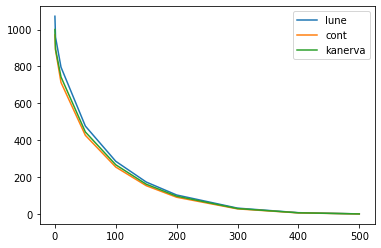

In [3]:
dvals = [0,1,10,50,100,150,200,300,400,500]
kanerv = [1000,894,743,445,267,162,97,30,7,1]
n =1000
r = 1000000
hdist = 451
lune = expected_intersection_lune(n, dvals, hdist, r)
cont = expected_intersection_continuous(n, dvals, hdist, r, True)
plt.plot(dvals, lune, label="lune")
plt.plot(dvals, cont, label="cont")
plt.plot(dvals, kanerv, label="kanerva")
plt.legend()

In [4]:
df = pd.DataFrame([dvals, lune, cont, kanerv]).T
df.columns = ["$d_v$", "Exact", "Continuous Approx.", "SDM Book"]
df["$d_v$"] = df["$d_v$"].astype(int)
df

,$d_v$,Exact,Continuous Approx.,SDM Book
0,0,1071.850049,970.769893,1000.0
1,1,958.436527,888.214545,894.0
2,10,795.873633,713.056676,743.0
3,50,476.873676,426.702117,445.0
4,100,285.830559,254.636411,267.0
5,150,173.627261,153.930182,162.0
6,200,103.460716,91.252432,97.0
7,300,32.323798,28.196980,30.0
8,400,7.597126,6.553410,7.0
9,500,1.101265,0.942394,1.0


In [8]:
import dataframe_image as dfi

dfi.export(df, "figures/CircleIntersectionDisagreementsTable.png")

# Simulations

Confirming the analytical results.

First want to test the SDM circle intersection matches the lune equation and not what Kanerva says. Then should compute the real variances used for the SNR equations and the memory capacity at a given distance for each of the models. 




In [5]:
n = 100
r = 10000
m = 100
hamm_dist = 35
normalize = True
image_directory = 'figures/'

params = {"n":n, "r":r, "m":m, "hamm_dist":hamm_dist, "norm":normalize}

params = SimpleNamespace(**params) # enables dot notation to be used to access dictionary.
params.fit_beta_and_plot_attention = False
params.plot_lines = False

In [6]:
params

namespace(n=100,
          r=10000,
          m=100,
          hamm_dist=35,
          norm=True,
          fit_beta_and_plot_attention=False,
          plot_lines=False)

## Reproduce circle intersection approximations

In [9]:
epochs = 20
xy_repeats = 1

dvals = [0,2,4,8,10,20, 40, 50]

#assert k>l, "wrong leeway or k values!"

algos = ["SDM"]

res = []
for e in range(epochs): 
    print('epoch:', e)
    
    # generate all neurons randomly as columns
    X_a = np.random.randint(2, size=(params.n,params.r))
    # focus coords for each neuron, indices to care about.
    for d in dvals:
        
        for i in range(xy_repeats):
    
            # generate 2 random points distance hamm_dist apart
            x = np.random.randint(2, size=(params.n,1))
            # random perturb
            y = np.copy(x).astype(bool)
            rand_inds = np.random.choice(params.n,d, replace=False)
            y[rand_inds] = np.invert(y[rand_inds]).astype(int)
            # compute circle intersect for each algorithm
            # uses the work to generate the random vectors etc
            
            for algo in algos: 
            
                # compute activations
                if algo == 'SDM':
                    x_activates = (d_parallel(X_a, x, params.n) <= params.hamm_dist).astype(int)
                    y_activates = (d_parallel(X_a, y, params.n) <= params.hamm_dist).astype(int)
                
                else: 
                    raise Exception()
                    
                intersect = x_activates.T@y_activates
                res.append((e, i, d, algo, intersect.item()))

df= pd.DataFrame(res)
df.columns = ['epoch', 'iter', 'c_dist', 'algo', 'intersect']
df

epoch: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
epoch: 18
epoch: 19


,epoch,iter,c_dist,algo,intersect
0,0,0,0,SDM,17
1,0,0,2,SDM,14
2,0,0,4,SDM,12
3,0,0,8,SDM,4
4,0,0,10,SDM,4
...,...,...,...,...,...
155,19,0,8,SDM,4
156,19,0,10,SDM,5
157,19,0,20,SDM,3
158,19,0,40,SDM,0


### Plot everything

Mean values [17.7  12.8   9.35  6.45  5.7   2.1   0.1   0.15]


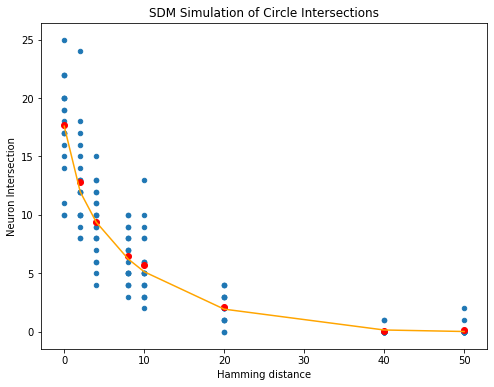

In [11]:
dvals = np.asarray(dvals)
for algo in algos: 
    
    fig, ax = plt.subplots(figsize=(8,6))
    df[df['algo']==algo].groupby(['epoch']).plot.scatter('c_dist','intersect', ax=ax)
    mean_values = df[df['algo']==algo].groupby(['c_dist']).mean()['intersect'].values
    plt.scatter(df['c_dist'].unique(), 
                mean_values, color='red')
    
    print('Mean values', mean_values)
    
    # plot the circle intersect theory
    if algo == 'SDM' or algo =='Kanerva SDM':
        real_target_freqs = SDM_lune(params, dvals, title=None, 
                                label_prefix=None)
    
    else: 
        raise Exception()
    
    plt.plot(dvals, real_target_freqs, color="orange")
    plt.title(algo)
    
    plt.title(algo+" Simulation of Circle Intersections")
    plt.xlabel('Hamming distance')
    plt.ylabel('Neuron Intersection')
    plt.gcf().savefig(image_directory+algo+"_IntersectionSimulation"+'.png', dpi=250)
    
    plt.show()
    
    print('==========')

## Simulations of SNR variance

Need to have a target pattern and produce perturbations from it. 
Then see how far away things are and the size of the update for each in a bitwise fashion. 
Compute the variance on this. 
Compute a signal to noise ratio for each simulation and see what their values are. 

Should be able to use the functions from my previous convergence simulations. 

Generate random neurons and random patterns. select one as a target from its pattern. perturb it to give the query. 
compute intersect with all patterns. via the neurons that store them. 

In [7]:
epochs = 200
target_repeats = 1

dvals = [0,2,4,8,10,20, 40, 50]

res = []
for e in range(epochs): 
    if e%10==0:
        print('epoch:', e)
    
    # generate all neurons randomly as columns. these are binary!!
    X_a = np.random.randint(2, size=(params.n,params.r))
    # generate all patterns randomly these are bipolar!! makes the variance calc easier
    P_a = np.random.randint(2, size=(params.n,params.m))
    P_p = (P_a*2) - 1
    
    # write to memory
    X_a_P_a_interactions = (d_parallel(P_a, X_a,params.n)<= params.hamm_dist).astype(int)
    #X_v = P_p@X_a_P_a_interactions
    
    # just focusing on SDM for now. 
    '''# for hyperplane variant needs to respect the coding frequency: 
    hyper_P_a_ones_ind = np.random.rand(params.n,params.m).argpartition(pattern_coding_rate,axis=0)[:pattern_coding_rate,:]
    
    # generate random indices without replacement for each column. 
    X_focus_inds = np.random.rand(params.n,params.r).argpartition(params.k,axis=0)[:params.k,:]
    X_focus_vals = X_a[X_focus_inds, np.arange(params.r)]
    
    hyper_X_inds = np.random.rand(params.n,params.r).argpartition(params.s,axis=0)[:params.s,:]
    # need to sort to ensure the indicies based comparison works
    hyper_X_inds = np.sort(hyper_X_inds, axis=0) '''
    
    for d in dvals:
        
        for i in range(target_repeats): # generate new targets with the same dataset. 
            
            # could parallelize all of this
            target_pat = np.random.choice(params.m)
            query = P_a[:,target_pat]
            # perturb it
            rand_inds = np.random.choice(params.n,d, replace=False)
            query[rand_inds] = np.invert(query[rand_inds].astype(bool)).astype(int)
            query = np.expand_dims(query, 1)
            query_neuron_inter = (d_parallel(X_a, query,params.n)<= params.hamm_dist).astype(int)
            
            # how many neurons intersect for each pattern and the query. 
            pattern_query_inter = X_a_P_a_interactions@query_neuron_inter
            signal = pattern_query_inter[target_pat]
            
            # can I use more bit positions here to compute better stats? 
            rand_bit_position = np.random.choice(params.n)
            P_p_bit = P_p[rand_bit_position, :]
            
            bit_pattern_summation = P_p_bit@pattern_query_inter
            
            to_append = [e, i, d, signal[0], bit_pattern_summation[0]]
            to_append += list(np.delete(pattern_query_inter.flatten() , target_pat ) )
            
            res.append(to_append)
    
df= pd.DataFrame(res)
#df.columns = ['epoch', 'iter', 'c_dist', 'signal', 'bit_pat_sum', 'all_intersections']
df.head()

epoch: 0
epoch: 10
epoch: 20
epoch: 30
epoch: 40
epoch: 50
epoch: 60
epoch: 70
epoch: 80
epoch: 90
epoch: 100
epoch: 110
epoch: 120
epoch: 130
epoch: 140
epoch: 150
epoch: 160
epoch: 170
epoch: 180
epoch: 190


,0,1,2,3,4,5,6,7,8,9,...,94,95,96,97,98,99,100,101,102,103
0,0,0,0,15,15,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,2,14,-14,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,4,8,7,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,8,9,10,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,10,5,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
df.rename(columns = {0: "epoch",
                    1: 'iter',
                    2: 'c_dist',
                    3: 'signal',
                    4: 'bit_pat_sum', 
                    }, 
          inplace = True)

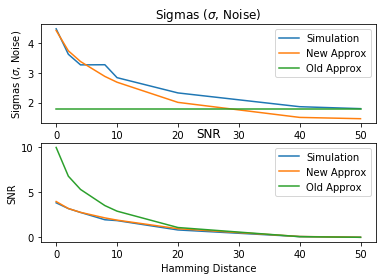

In [9]:

fig, axs = plt.subplots(2)#,figsize=(18,20) )

signals_by_dist = df.groupby('c_dist').mean()['signal'].values
#noise_by_dist = np.sqrt(df.groupby('c_dist').var()['bit_pat_sum'].values)

sum_var_noise_terms = df.groupby('c_dist').var().iloc[:, 4:].sum(1).values
sum_var_signal_terms = df.groupby('c_dist').var()['signal'].values
sum_vars = sum_var_noise_terms+sum_var_signal_terms

axs[0].plot(dvals, np.sqrt(sum_vars),label="Simulation")
axs[1].plot(dvals, signals_by_dist/np.sqrt(sum_vars),label="Simulation")

# Jaeckell calculation: 

target_freqs = SDM_lune(params, dvals, title=None, 
                                label_prefix=None)
    
    
'''if algo == 'Kanerva SDM':
    '''

algo_max_dist = target_freqs[-1]

sigmas = np.sqrt( target_freqs + ( (params.m-1)*(algo_max_dist+algo_max_dist**2) ) )

snrs = target_freqs/sigmas

axs[0].plot(dvals, sigmas, label="New Approx")
axs[1].plot(dvals, snrs, label="New Approx")


# old SDM 

c_p = (hamm_dist-(params.n/2))/np.sqrt(params.n/4)
cfrac = binom.cdf(hamm_dist, params.n, 0.5)
h = -f(0.5, c_p)
sigmas = np.sqrt( (1+ (((h**2) *params.r)/(4*cfrac**2 *params.n))) *(cfrac**2)*params.r*params.m )
sigmas = np.repeat(sigmas, len(dvals))

snrs = target_freqs/sigmas

axs[0].plot(dvals, sigmas, label="Old Approx")
axs[1].plot(dvals, snrs, label="Old Approx")

for i, label in enumerate(['Sigmas ($\sigma$, Noise)', 'SNR']):
    axs[i].set_title(label)
    axs[i].set(ylabel=label)
    axs[i].legend()


plt.xlabel('Hamming Distance')
plt.gcf().savefig(image_directory+"SDM_SNR-Simulation"+'.png', dpi=250)
    
plt.show()